## Loading the Data

In [1]:
# Download dataset
!kaggle datasets download -d kartikbhatnagar18/sustainable-development-goals -f osdg-community-dataset-v21-09-30.csv

Dataset URL: https://www.kaggle.com/datasets/kartikbhatnagar18/sustainable-development-goals
License(s): unknown
 62%|███████████████████████▋              | 5.00M/8.04M [00:00<00:00, 32.5MB/s]
100%|██████████████████████████████████████| 8.04M/8.04M [00:00<00:00, 48.2MB/s]


In [2]:
# View downloaded files
!ls -d $PWD/*

/kaggle/working/osdg-community-dataset-v21-09-30.csv.zip


In [3]:
# Unzip files and delete initial zip file
!unzip \*.zip && rm *.zip

Archive:  osdg-community-dataset-v21-09-30.csv.zip
  inflating: osdg-community-dataset-v21-09-30.csv  


In [4]:
# install required libraries
!pip install datasets
!pip install transformers
!pip install wordcloud

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torch.nn.functional import cross_entropy
from transformers import pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from umap import UMAP

# Set options
pd.set_option('display.float_format', str)
np.set_printoptions(suppress=True)  # print full forms or values

2024-08-07 10:54:56.349961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 10:54:56.350071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:54:56.496426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Load dataset into pandas dataframe
data = pd.read_csv('osdg-community-dataset-v21-09-30.csv')

 # Preview dataset
data.head()

doi                           text_id  \
0  10.6027/9789289342698-7-en  00021941702cd84171ff33962197ca1f   
1        10.18356/eca72908-en  00028349a7f9b2485ff344ae44ccfd6b   
2  10.1787/9789264289062-4-en  0004eb64f96e1620cd852603d9cbe4d4   
3     10.1787/5k9b7bn5qzvd-en  0006a887475ccfa5a7f5f51d4ac83d02   
4  10.1787/9789264258211-6-en  0006d6e7593776abbdf4a6f985ea6d95   

                                                text  sdg  labels_negative  \
0  From a gender perspective, Paulgaard points ou...    5                1   
1  Labour legislation regulates maximum working h...   11                2   
2  The average figure also masks large difference...    3                1   
3  The extent to which they are akin to corruptio...    3                1   
4  A region reporting a higher rate will not earn...    3                2   

   labels_positive          agreement  
0                7               0.75  
1                1 0.3333333333333333  
2                6 0.7142857142857143  
3                2 0.3333333333333333  
4                2                0.0

In [7]:
# Keep relevant columns
data = data[['text', 'sdg']]
data.head()

text  sdg
0  From a gender perspective, Paulgaard points ou...    5
1  Labour legislation regulates maximum working h...   11
2  The average figure also masks large difference...    3
3  The extent to which they are akin to corruptio...    3
4  A region reporting a higher rate will not earn...    3

## Review Data Information

In [8]:
# Sheck the dimensions of the train data
n_rows= data.shape[0]
print(f'There are {n_rows} samples in the train dataset')

There are 32121 samples in the train dataset


In [9]:
# Check vital data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32121 entries, 0 to 32120
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    32121 non-null  object
 1   sdg     32121 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 502.0+ KB


In [10]:
# Show sample text data
for i in range(3):
  print(data['text'].sample(1).values[0] + '\n')

In contrast, import measures play only a minor role in relative terms. Support to biofuel use, mainly in the form of tax rebates or exemptions, are most widely spread across the countries covered by the database, but 23 of the 34 countries also apply biofuel mandates, requiring a minimum quantity or share of biofuels to be used in the transport fuel mix. Other forms of support, such as output-based payments or subsidies for the handling and storage of biofuels, play a comparatively smaller role across countries.

Meeting water governance challenges calls for a mix of well-integrated policy measures. This can be difficult to achieve in a context of fragmented responsibilities among various public actors as decisions are made at different territorial levels (international, national, regional, municipal, basin, etc.). Greater policy coherence is called for, both horizontally and vertically, among different institutions.

In 2009 the warehouse storage capacity was only 1.5 million tonnes c

In [11]:
# Show the distict classes 
print(f'There are {data["sdg"].nunique()} distinct SDG categories in the data \n {np.sort(data["sdg"].unique())}')

There are 15 distinct SDG categories in the data 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [12]:
# Define the 15 SDGs in the data
sdg_goals = {
    1: "No Poverty",
    2: "Zero Hunger",
    3: "Good Health and Well-being",
    4: "Quality Education",
    5: "Gender Equality",
    6: "Clean Water and Sanitation",
    7: "Affordable and Clean Energy",
    8: "Decent Work and Economic Growth",
    9: "Industry, Innovation, and Infrastructure",
    10:"Reduced Inequality",
    11:"Sustainable Cities and Communities",
    12:"Responsible Consumption and Production",
    13:"Climate Action",
    14:"Life Below Water",
    15:"Life on Land"
}

In [13]:
# check for duplicates in the data
data.duplicated(subset=['text']).any()

False

In [14]:
# check for missing values in the data
data.isnull().any()

text    False
sdg     False
dtype: bool

## Exploratory Data Analysis

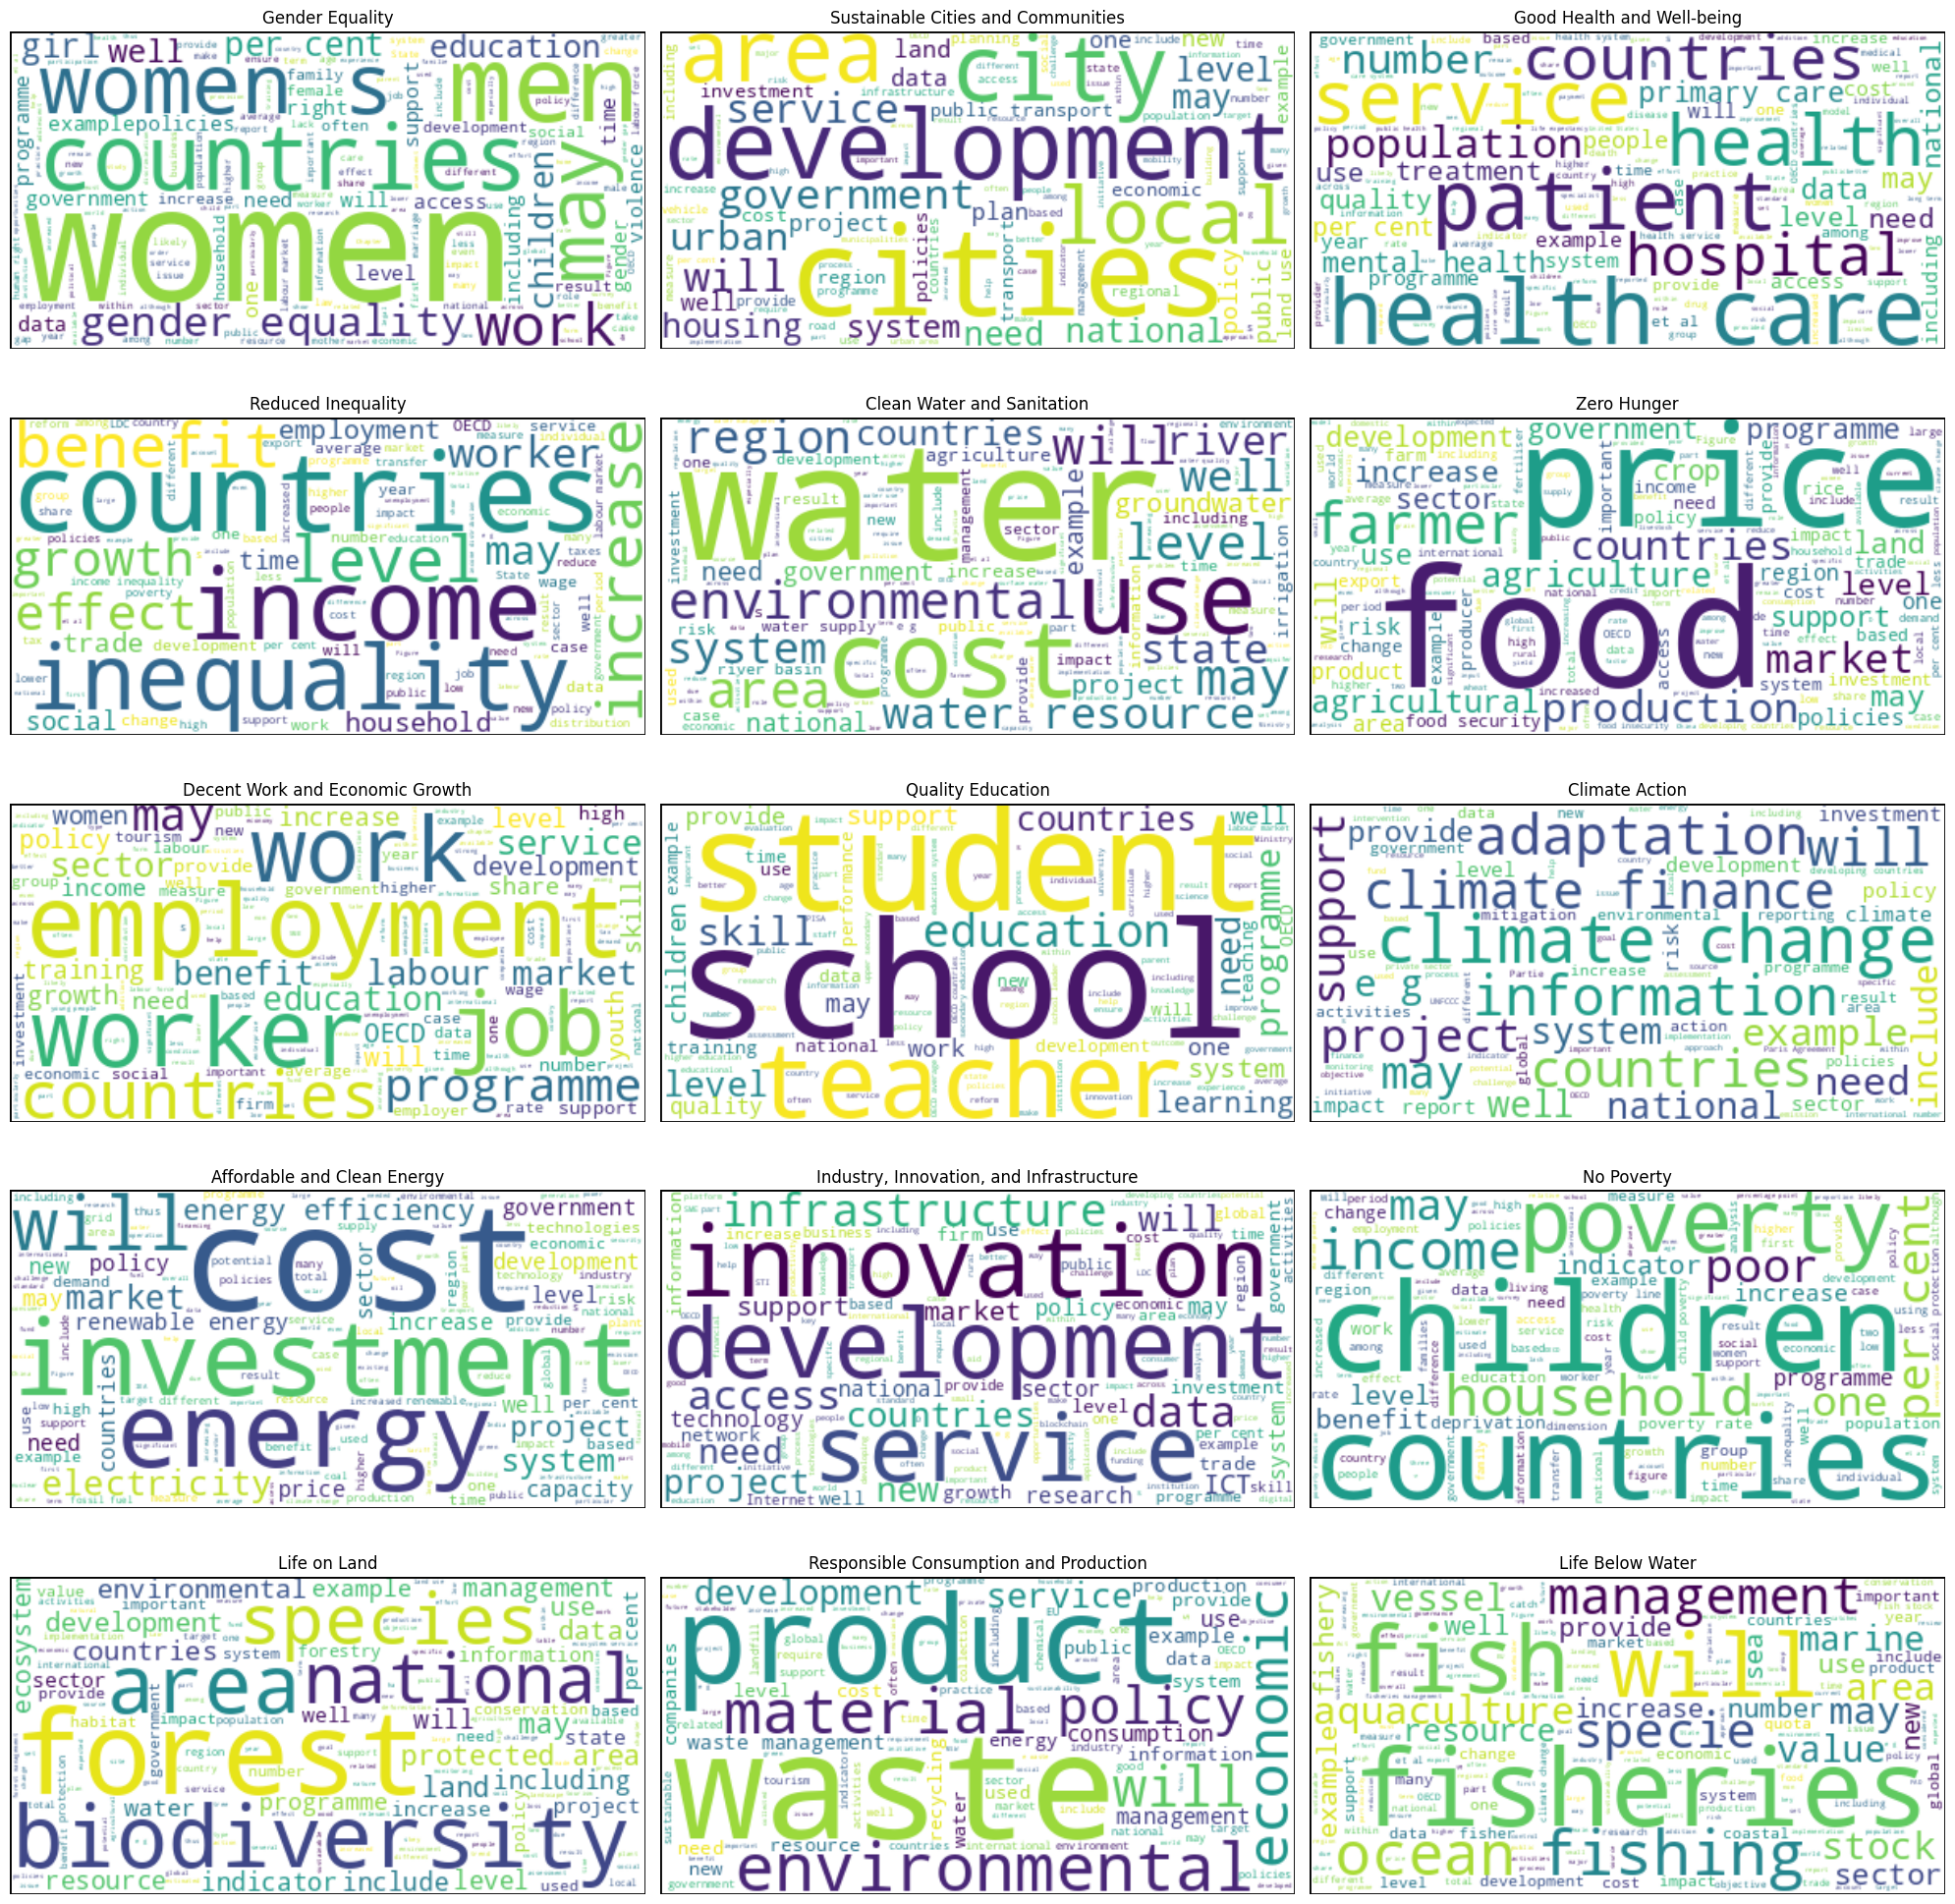

In [15]:
# Display wordclouds per category
stopwords = set(STOPWORDS)  # Define stopwords

# Get unique categories
categories = data['sdg'].unique()

# Calculate number of rows and columns
rows = 5
cols = 3

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through each category and corresponding subplot axis
for idx, category in enumerate(categories):
    # Get the text for the current category
    category_text = data[data['sdg'] == category]['text']

    # Generate a word cloud for the current category
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(category_text))

    # Display the word cloud on the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(sdg_goals[category])
    axes[idx].axis('off')

    # Add a rectangular box around each subplot
    rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none', transform=axes[idx].transAxes)
    axes[idx].add_patch(rect)

# Turn off any remaining empty subplots
for i in range(len(categories), len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

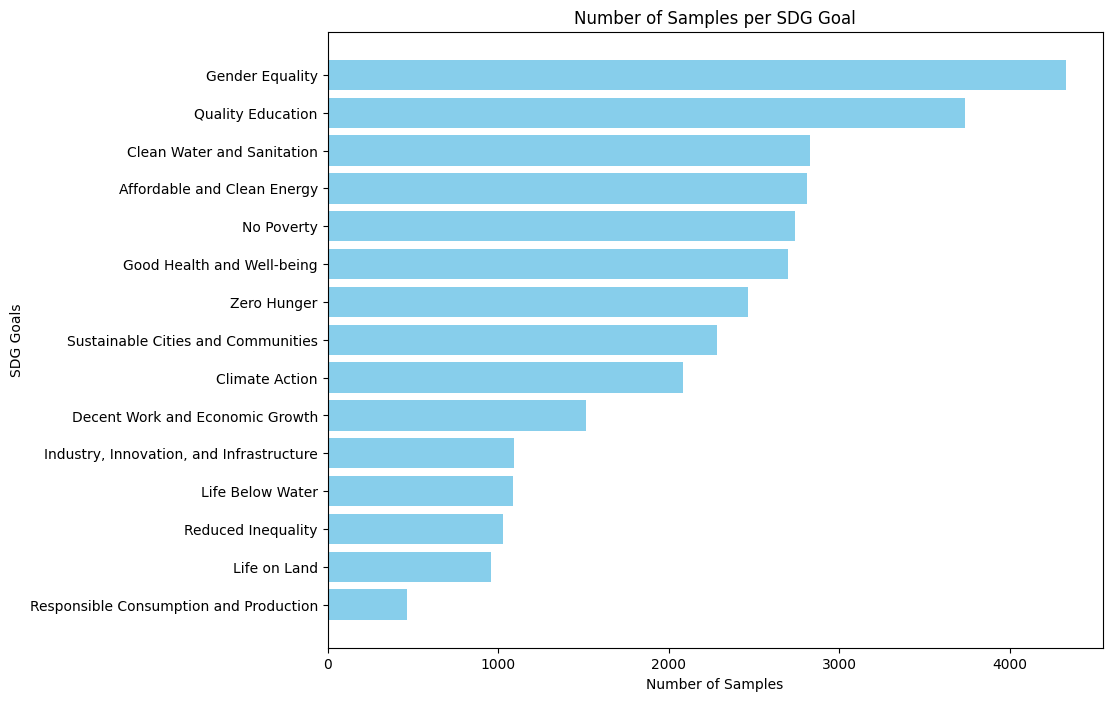

In [16]:
# Show data distribution per category

class_counts = data['sdg'].value_counts() # Count the number of samples per class

# Replace the index values with the exact SDG goals
class_counts.index = class_counts.index.map(sdg_goals)

# Create the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Number of Samples')
plt.ylabel('SDG Goals')
plt.title('Number of Samples per SDG Goal')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()

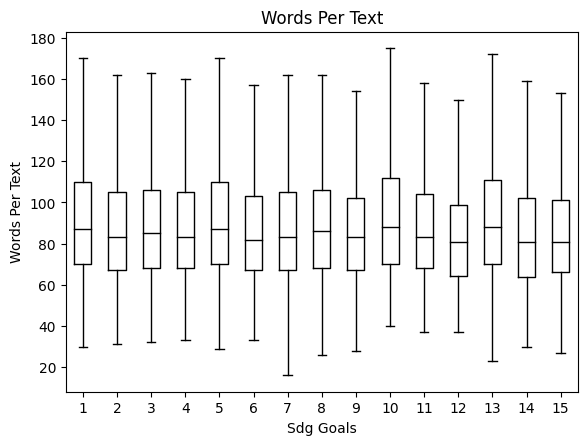

In [17]:
# check distribution of text length
df = data.copy()
df["Words Per Text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Text", by="sdg", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("Sdg Goals")
plt.ylabel("Words Per Text")
plt.show()

In [18]:
# Get max token length
max_token = df["Words Per Text"].max()
print(f'The maximum token length is {max_token}')

The maximum token length is 226


## Data Preprocessing

In [19]:
# Split data into train and test sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sdg'])
train_data.shape, val_data.shape

((25696, 2), (6425, 2))

In [20]:
# Convert DataFrame to Dataset type
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)

In [21]:
# Define tokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# Tokenize text inputs
train_encoded = train_ds.map(tokenize, batched=True, batch_size=None)
val_encoded = val_ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/25696 [00:00<?, ? examples/s]

Map:   0%|          | 0/6425 [00:00<?, ? examples/s]

In [23]:
# Show details of tokenized data
train_encoded.features

{'text': Value(dtype='string', id=None),
 'sdg': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [24]:
# Load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [25]:
# Extract hidden state of inputs
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [26]:
# Map 'sdg' field to 'labels'
train_encoded = train_encoded.map(lambda x: {'label': [label - 1 for label in x['sdg']]}, batched=True)
val_encoded = train_encoded.map(lambda x: {'label': [label - 1 for label in x['sdg']]}, batched=True)

# Set inputs to tensor format
train_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])
val_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

# Remove sdg column from dataset
train_encoded = train_encoded.remove_columns(["sdg"])

# # Extract hidden state of inputs
# # Use this if you have enough computation resources
## Else use the code below
# train_hidden = train_encoded.map(extract_hidden_states, batched=True)
# val_hidden = val_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/25696 [00:00<?, ? examples/s]

Map:   0%|          | 0/25696 [00:00<?, ? examples/s]

In [ ]:
# Reduce batch size to manage memory
batch_size = 8

# Process the dataset in smaller batches and clear CUDA cache
train_hidden = []
for i in range(0, len(train_encoded), batch_size):
    batch = train_encoded.select(range(i, min(i + batch_size, len(train_encoded))))
    train_hidden.append(batch.map(extract_hidden_states, batched=True))
    torch.cuda.empty_cache()  # Clear cache after each batch

train_hidden = datasets.concatenate_datasets(train_hidden)

# Repeat the process for validation set
val_hidden = []
for i in range(0, len(val_encoded), batch_size):
    batch = val_encoded.select(range(i, min(i + batch_size, len(val_encoded))))
    val_hidden.append(batch.map(extract_hidden_states, batched=True))
    torch.cuda.empty_cache()  # Clear cache after each batch

val_hidden = datasets.concatenate_datasets(val_hidden)

In [30]:
# Get train and validation inputs and labels
X_train = np.array(train_hidden["hidden_state"])
X_valid = np.array(val_hidden["hidden_state"])
y_train = np.array(train_hidden["label"])
y_valid = np.array(val_hidden["label"])

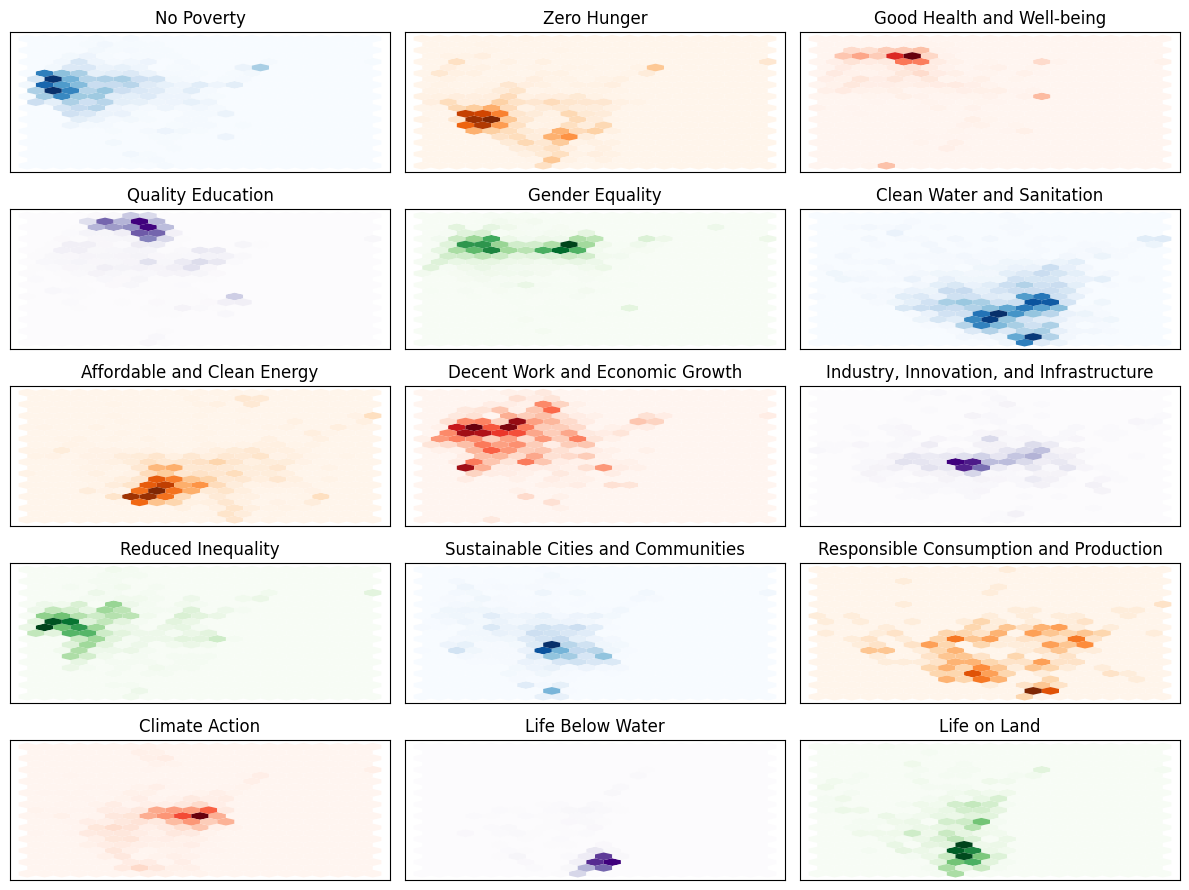

In [31]:
# Visualizing the features in 2D
X_scaled = MinMaxScaler().fit_transform(X_train) # Scale features to [0,1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled) # Initialize and fit UMAP
df_emb = pd.DataFrame(mapper.embedding_, columns=["X1", "X2"]) # Create a DataFrame of 2D embeddings
df_emb["label"] = y_train

fig, axes = plt.subplots(5, 3, figsize=(12,9))
axes = axes.flatten()
cmaps = ["Blues", "Oranges", "Reds", "Purples", "Greens"] * 3
labels = sdg_goals.values()
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X1"], df_emb_sub["X2"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

## Model Development & Evaluation

In [32]:
# Evaluate a baseline model
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(X_train, y_train)
baseline_score = dummy_clf.score(X_valid, y_valid)
print(f"Baseline Score: {baseline_score}")

Baseline Score: 0.13469022415940224


In [33]:
# Train and evaluate a logistic model
lr_clf = LogisticRegression(max_iter=3000) # We increase `max_iter` to guarantee convergence
lr_clf.fit(X_train, y_train)  # Train the classifier
lr_score = lr_clf.score(X_valid, y_valid) # Evaluate the classifier

print(f"Logistic Regression Score: {lr_score}")

Logistic Regression Score: 0.8026930261519303


In [34]:
# To plot confusion matrix
def plot_confusion_matrix(y_valid, y_predicted):
    plt.figure(figsize=(15,6))
    cm = confusion_matrix(y_valid, y_predicted)
    sns.heatmap(cm, annot= True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    ticks = range(1,16)
    labels = np.sort(data["sdg"].unique())
    plt.xticks(labels, ticks)
    plt.yticks(labels, ticks)
    plt.show()


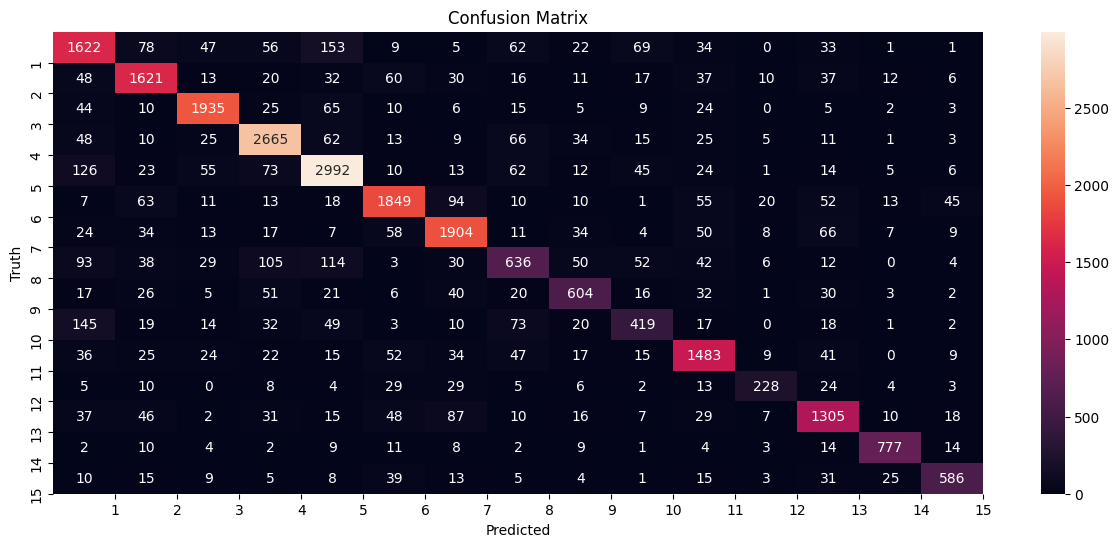

In [35]:
# display confusion matrix
y_predicted = lr_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_predicted)

In [42]:
# display classification report
print('Classification Report of Logistic Regression Model \n',
      classification_report(y_valid, y_predicted, target_names=[str(num) for num in range(1,16)]
))

Classification Report of Logistic Regression Model 
               precision    recall  f1-score   support

           1       0.72      0.74      0.73      2192
           2       0.80      0.82      0.81      1970
           3       0.89      0.90      0.89      2158
           4       0.85      0.89      0.87      2992
           5       0.84      0.86      0.85      3461
           6       0.84      0.82      0.83      2261
           7       0.82      0.85      0.84      2246
           8       0.61      0.52      0.56      1214
           9       0.71      0.69      0.70       874
          10       0.62      0.51      0.56       822
          11       0.79      0.81      0.80      1829
          12       0.76      0.62      0.68       370
          13       0.77      0.78      0.78      1668
          14       0.90      0.89      0.90       870
          15       0.82      0.76      0.79       769

    accuracy                           0.80     25696
   macro avg       0.78    

In [43]:
# Define pretrained model to fintune
num_labels = len(train_encoded['label'].unique())
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

# Define Performance metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Define Training Arguments
batch_size = 8
logging_steps = len(train_encoded) // batch_size
model_name = f"{model_ckpt}-sdg-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                 report_to=[])


# Define Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded,
                  eval_dataset=val_encoded,
                  tokenizer=tokenizer)

# Train finetuned model
trainer.train();

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

In [44]:
# Get predicted outputs 
preds_output = trainer.predict(val_encoded)

# Show performance on validation set
preds_output.metrics

# Get labels of predicted outputs
y_preds = np.argmax(preds_output.predictions, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


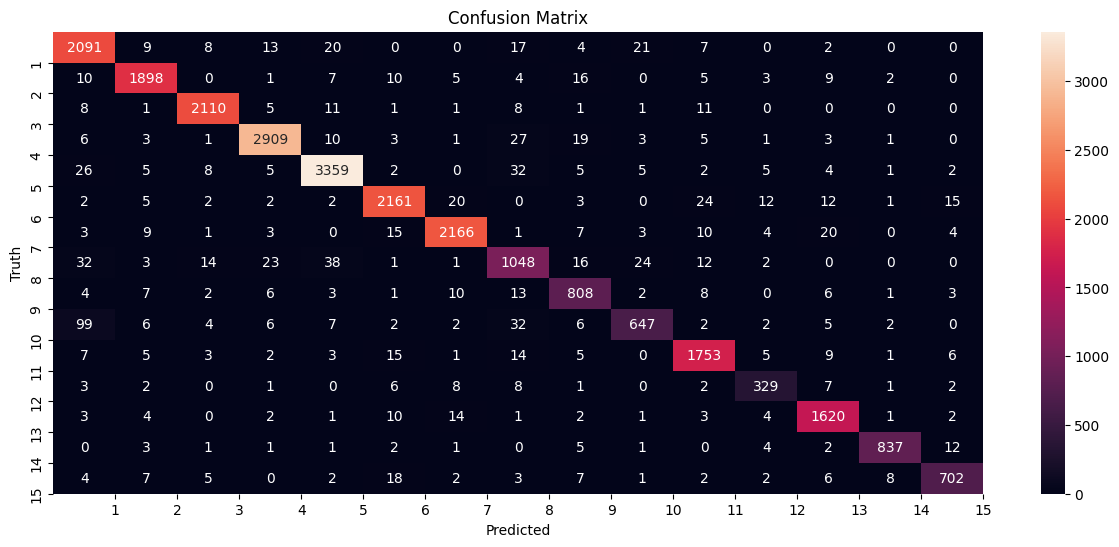

In [46]:
# Plot confusion matrix of finetuned model
plot_confusion_matrix(y_valid, y_preds)

In [49]:
# display classification report
print('Classification Report of finetuned Distilbert model \n',
      classification_report(y_valid, y_preds, target_names=[str(num) for num in range(1,16)]
))

Classification Report of finetuned Distilbert model 
               precision    recall  f1-score   support

           1       0.91      0.95      0.93      2192
           2       0.96      0.96      0.96      1970
           3       0.98      0.98      0.98      2158
           4       0.98      0.97      0.97      2992
           5       0.97      0.97      0.97      3461
           6       0.96      0.96      0.96      2261
           7       0.97      0.96      0.97      2246
           8       0.87      0.86      0.87      1214
           9       0.89      0.92      0.91       874
          10       0.91      0.79      0.85       822
          11       0.95      0.96      0.95      1829
          12       0.88      0.89      0.89       370
          13       0.95      0.97      0.96      1668
          14       0.98      0.96      0.97       870
          15       0.94      0.91      0.93       769

    accuracy                           0.95     25696
   macro avg       0.94   

In [53]:
# Save the model
trainer.save_model("distilbert-sdg-finetuned")

# Save the model and tokenizer
tokenizer.save_pretrained("distilbert-sdg-finetuned")

('distilbert-sdg-finetuned/tokenizer_config.json',
 'distilbert-sdg-finetuned/special_tokens_map.json',
 'distilbert-sdg-finetuned/vocab.txt',
 'distilbert-sdg-finetuned/added_tokens.json',
 'distilbert-sdg-finetuned/tokenizer.json')

In [58]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# Load the model and tokenizer from the local directory
model_path = "distilbert-sdg-finetuned"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Initialize the pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [78]:
# Load the pipeline with the locally saved model
# pipe = pipeline("SDG Classification", model="distilbert-sdg-model", tokenizer="distilbert-sdg-model", device=device)

sample_text = ''' In many parts of the world, millions of people still lack access to basic healthcare services. 
                  Children and adults suffer from preventable diseases due to insufficient medical resources and 
                  inadequate infrastructure. By focusing on improving healthcare systems, we can significantly reduce 
                  mortality rates and enhance the quality of life for countless individuals. Investing in health 
                  education and promoting healthy lifestyles are crucial steps towards achieving a healthier future. 
                  Collaborative efforts among governments, NGOs, and communities are essential to ensure that everyone, 
                  regardless of their socio-economic status, has the opportunity to live a long and healthy life."
             '''
print("Dialogue:")
print(sample_text)
print("\nModel Prediction:")
prediction = pipe(sample_text,)[0]
label_ = prediction['label']
score = prediction['score']
label_ = int(label_.split('_')[-1])
sdg_goal = list(sdg_goals.values())[label_]
print(sdg_goal)

print("\nScore: ")
print(score)

Dialogue:
 In many parts of the world, millions of people still lack access to basic healthcare services. 
                  Children and adults suffer from preventable diseases due to insufficient medical resources and 
                  inadequate infrastructure. By focusing on improving healthcare systems, we can significantly reduce 
                  mortality rates and enhance the quality of life for countless individuals. Investing in health 
                  education and promoting healthy lifestyles are crucial steps towards achieving a healthier future. 
                  Collaborative efforts among governments, NGOs, and communities are essential to ensure that everyone, 
                  regardless of their socio-economic status, has the opportunity to live a long and healthy life."
             

Model Prediction:
Good Health and Well-being

Score: 
0.993558943271637


In [79]:
sample_text = ''' Millions in third-world countries face extreme poverty, lacking access to basic necessities like food,
                    clean water, and education. Urgent efforts are needed to address these challenges and improve their 
                    living conditions.""
             '''
print("Dialogue:")
print(sample_text)
print("\nModel Prediction:")
prediction = pipe(sample_text,)[0]
label_ = prediction['label']
score = prediction['score']
label_ = int(label_.split('_')[-1])
sdg_goal = list(sdg_goals.values())[label_]
print(sdg_goal)

print("\nScore: ")
print(score)

Dialogue:
 Millions in third-world countries face extreme poverty, lacking access to basic necessities like food,
                    clean water, and education. Urgent efforts are needed to address these challenges and improve their 
                    living conditions.""
             

Model Prediction:
No Poverty

Score: 
0.7070779204368591
